## Import Statements

In [12]:
import gc

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split as tts

from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [13]:
class Learner():

    def __init__(self, classes : tuple, n_neighbors : tuple, train_df : pd.DataFrame, test_df : pd.DataFrame, submission_df : pd.DataFrame):
        self.classes = classes
        self.n_neighbors = n_neighbors
        
        self.train_df = train_df
        self.test_df = test_df
        self.submission_df = submission_df

        self.scored_classifiers = []
        self.classification_reports = []
        self.f1_score = []
    

    def split_dataset(self):
        self.train_input, self.validation_input, self.train_output, self.validation_output = tts(self.train_df.drop(columns=["building_id", "damage_grade"]), self.train_df["damage_grade"], test_size=0.3)
        return self.train_input, self.validation_input, self.train_output, self.validation_output
    

    def create_file(self, predicted_output, file_num : str, obj =True):
        if predicted_output.shape[0] == self.submission_df.shape[0]:
            print(True)
            submission = self.submission_df.copy()
            for (idx,data) in submission["damage_grade"].iteritems():
                submission["damage_grade"][idx] = predicted_output[idx]    
            if obj:
                submission.to_csv("../datasets/submissions_knn/submission_" + file_num + ".csv", index=False, header=True)
            else:
                submission.to_csv("../datasets/submissions_knn/submission_norm_" + file_num + ".csv", index=False, header=True)
            del submission
            gc.collect()
    

    def create_classifier(self, neighbors : int, weights : str, algorithm : str):
        return KNeighborsClassifier(n_neighbors=neighbors, weights=weights, algorithm=algorithm)
    

    def train_model(self, weight : str, algorithm : str):
        dataset = self.split_dataset()
        for neighbor in neighbors:            
            classifier = self.create_classifier(neighbors=neighbor, weights=weight, algorithm=algorithm)
            classifier.fit(dataset[0], dataset[2])
            predicted_output = classifier.predict(dataset[1])
            acc_score = accuracy_score(predicted_output, dataset[3])

            self.classification_reports.append(self.create_classification_report(dataset[3], predicted_output)                )
            self.scored_classifiers.append((neighbor, weight, classifier, acc_score))
            self.f1_score.append(self.get_f1_score(dataset[3], predicted_output))
        del dataset
        gc.collect()
    

    def test_model(self, classifier : KNeighborsClassifier, file_num : int,  create_file=True, obj=True):
        self.test_df = self.test_df.fillna(self.test_df.median())
        predicted_output = classifier.predict(self.test_df.drop(columns=["building_id"]))
        if create_file:
            self.create_file(predicted_output, str(file_num), obj=obj)
        return predicted_output

    
    def plot_confusion_matrix(self, classifier : KNeighborsClassifier):
        plot_conf_matrix = plot_confusion_matrix(classifier, self.validation_input, self.validation_output, display_labels=classes, cmap=plt.cm.Blues, normalize='true') 
        return plot_conf_matrix
    
    def create_classification_report(self, validation_output, predicted_output):
        report = classification_report(validation_output, predicted_output, output_dict=True)   
        return pd.DataFrame(report).transpose()
    
    def get_cross_validation_score(self, classifier : KNeighborsClassifier):
        return cross_val_score(classifier, self.validation_input, self.validation_output, cv=3)
    
    def get_f1_score(self, validation_output, predicted_output):
        return f1_score(y_true=validation_output, y_pred=predicted_output, average='micro')

## Public Variables

In [14]:
classes = (1, 2, 3)
neighbors = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
weights = ('uniform', 'distance')
algorithm = ('ball_tree', 'kd_tree', 'brute', 'auto')

## Datasets

In [15]:
train_norm_df = pd.read_csv("../datasets/preprocessed/train_normalize.csv")
test_norm_df = pd.read_csv("../datasets/preprocessed/test_normalize.csv")

train_obj_df = pd.read_csv("../datasets/preprocessed/train_no_object.csv")
test_obj_df = pd.read_csv("../datasets/preprocessed/test_no_object.csv")

submission_df = pd.read_csv("../datasets/submission_format.csv")

## Train for No object data then predict test values

In [16]:
learner = None 
if learner != None:
    del learner
    gc.collect()

In [17]:
learner = Learner(classes=classes, n_neighbors=neighbors, train_df=train_obj_df, test_df=test_obj_df, submission_df=submission_df)

In [18]:
learner.train_model(weight=weights[1], algorithm=algorithm[3])

In [19]:
for report in learner.classification_reports:
    print(report)
    print()
    print("*" * 90)
    print()

precision    recall  f1-score       support
1              0.521883  0.502726  0.512126   7519.000000
2              0.718872  0.718305  0.718588  44360.000000
3              0.623079  0.630446  0.626741  26302.000000
accuracy       0.668014  0.668014  0.668014      0.668014
macro avg      0.621278  0.617159  0.619152  78181.000000
weighted avg   0.667700  0.668014  0.667832  78181.000000

******************************************************************************************

              precision    recall  f1-score       support
1              0.516462  0.525735  0.521057   7519.000000
2              0.715514  0.731515  0.723426  44360.000000
3              0.634916  0.607710  0.621015  26302.000000
accuracy       0.670073  0.670073  0.670073      0.670073
macro avg      0.622297  0.621653  0.621833  78181.000000
weighted avg   0.669255  0.670073  0.669510  78181.000000

******************************************************************************************

              pr

In [20]:
learner.f1_score

[0.6680139675880329,
 0.6700732914646781,
 0.6870339340760543,
 0.6928153899284992,
 0.6982131208349854,
 0.7028306110180222,
 0.7051457515253067,
 0.7067957687929293,
 0.7079981069569332,
 0.7083306685767642,
 0.7087783476803826,
 0.7098271958660034,
 0.7096737058876198,
 0.7098271958660034,
 0.7097120783822155]

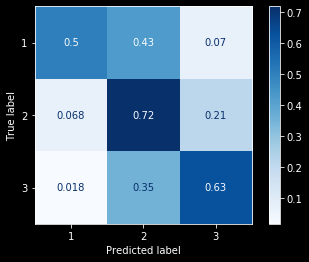

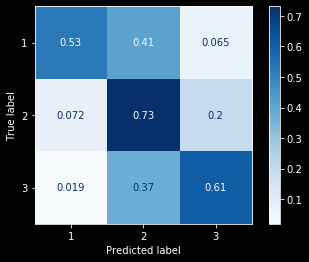

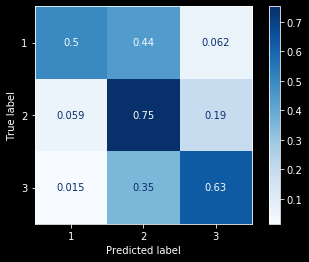

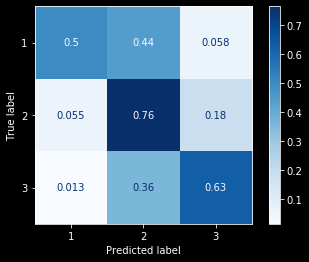

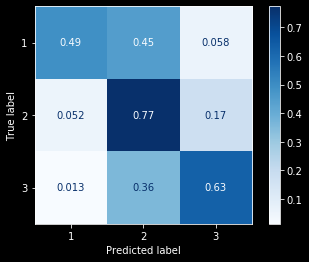

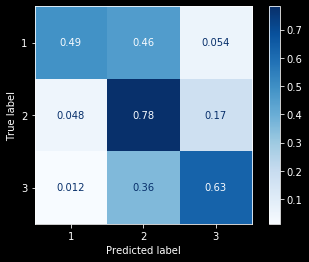

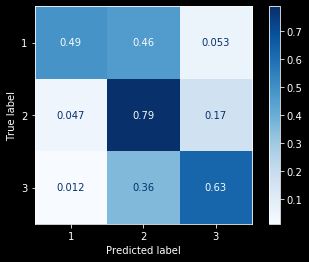

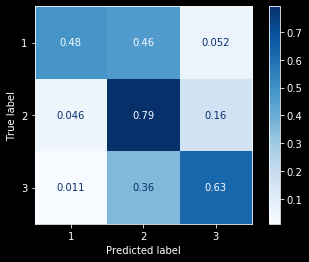

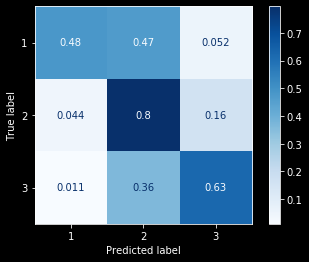

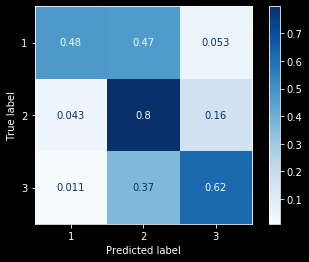

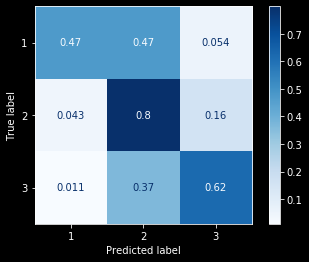

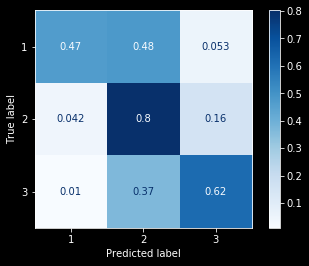

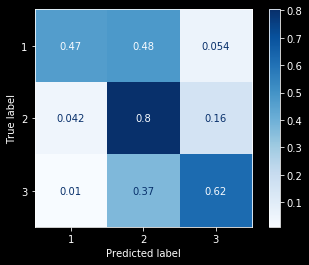

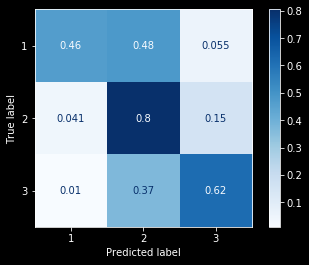

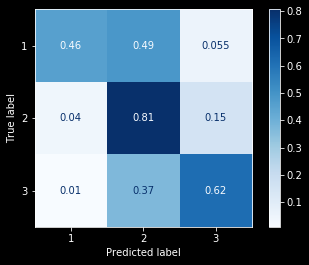

In [21]:
for tuple_item in learner.scored_classifiers:
    plot = learner.plot_confusion_matrix(classifier=tuple_item[2])
plt.show()

In [22]:
for tuple_item in learner.scored_classifiers:
    predicted_output = learner.test_model(classifier=tuple_item[2], file_num=str(tuple_item[0])+tuple_item[1])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
